<a href="https://colab.research.google.com/github/iamthemarkjack/Patient_Readmission_Prediction/blob/main/Hospital_Readmission%20EDA%20%26%20Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vanpatangan_readmission_dataset_path = kagglehub.dataset_download('vanpatangan/readmission-dataset')

print('Data source import complete.')


Data source import complete.


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Apply the default theme
sns.set_theme()

# Load Datasets

In [3]:
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')
# sample_sub = pd.read_csv('/kaggle/input/readmission-dataset/sample_submission.csv')

# Data Summary

In [4]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [5]:
print("Training Data Summary")
display(check(train))
display(train.head())
print("Testing Data Summary")
display(check(test))
display(test.head())
print("Sample Submission Summary")
display(check(sample_sub))
display(sample_sub.head())

Training Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,age,int64,5000,72,0,4
1,gender,object,5000,2,0,4
2,primary_diagnosis,object,5000,5,0,4
3,num_procedures,int64,5000,10,0,4
4,days_in_hospital,int64,5000,14,0,4
5,comorbidity_score,int64,5000,5,0,4
6,discharge_to,object,5000,4,0,4
7,readmitted,int64,5000,2,0,4


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


Testing Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,age,int64,2000,72,0,1
1,gender,object,2000,2,0,1
2,primary_diagnosis,object,2000,5,0,1
3,num_procedures,int64,2000,10,0,1
4,days_in_hospital,int64,2000,14,0,1
5,comorbidity_score,int64,2000,5,0,1
6,discharge_to,object,2000,4,0,1


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to
0,52,Male,Heart Disease,3,9,3,Home
1,47,Female,Diabetes,2,4,0,Skilled Nursing Facility
2,72,Female,Heart Disease,7,12,4,Home
3,18,Female,COPD,5,14,3,Home
4,32,Male,Heart Disease,9,2,4,Rehabilitation Facility


Sample Submission Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Patient_ID,int64,2000,2000,0,0
1,readmitted,int64,2000,2,0,0


,Patient_ID,readmitted
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


# EDA
**Investigating duplicated rows**

In [6]:
# View all duplicated rows including the first occurrence
all_duplicates = train[train.duplicated(keep=False)]
all_duplicates

,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
128,79,Male,Diabetes,3,8,1,Rehabilitation Facility,0
135,79,Male,Diabetes,3,8,1,Rehabilitation Facility,0
182,33,Female,Heart Disease,1,1,1,Home,0
319,49,Male,Heart Disease,2,6,1,Home,0
1227,56,Male,Heart Disease,3,5,4,Home Health Care,0
3091,33,Female,Heart Disease,1,1,1,Home,0
3552,56,Male,Heart Disease,3,5,4,Home Health Care,0
3671,49,Male,Heart Disease,2,6,1,Home,0


In [7]:
# Add Patient_ID to the training data
train_with_id = pd.concat([train, sample_sub['Patient_ID']], axis=1)

# Check for duplicates using all columns, including the newly added Patient_ID
duplicates = train_with_id[train_with_id.duplicated(keep=False)]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


In [8]:
# Keeping the rows since they are unique entries for each Patient_ID
# Remove Patient_ID column from the training data
train = train_with_id.drop('Patient_ID', axis=1)

# Visualizations

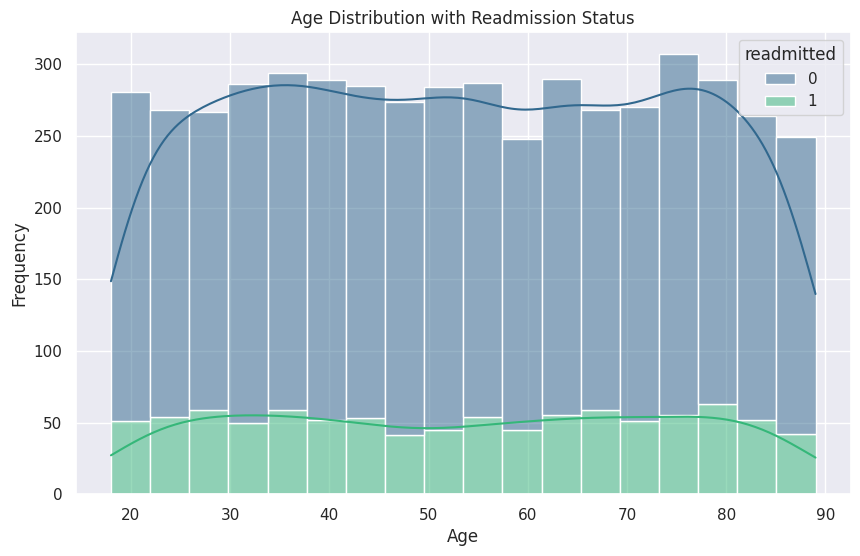

In [9]:
# Distribution of Age and Readmission Rates
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='age', hue='readmitted', multiple='stack', kde=True, palette='viridis')
plt.title('Age Distribution with Readmission Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

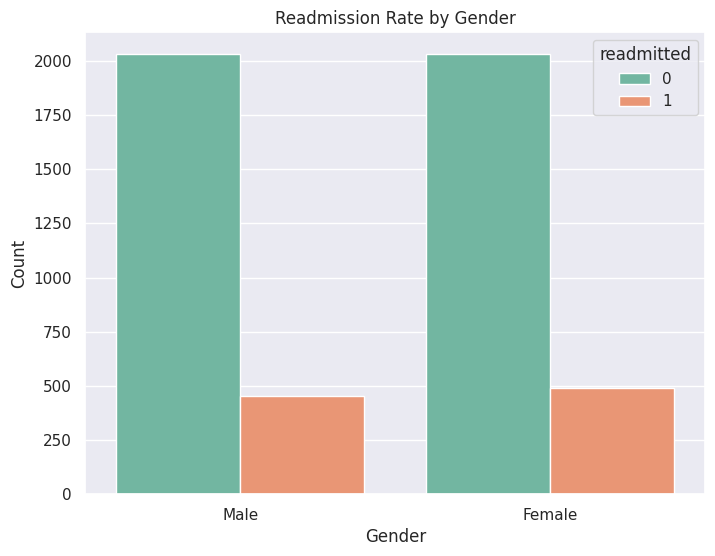

In [10]:
# Gender wise Readmission Rates
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='gender', hue='readmitted', palette='Set2')
plt.title('Readmission Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

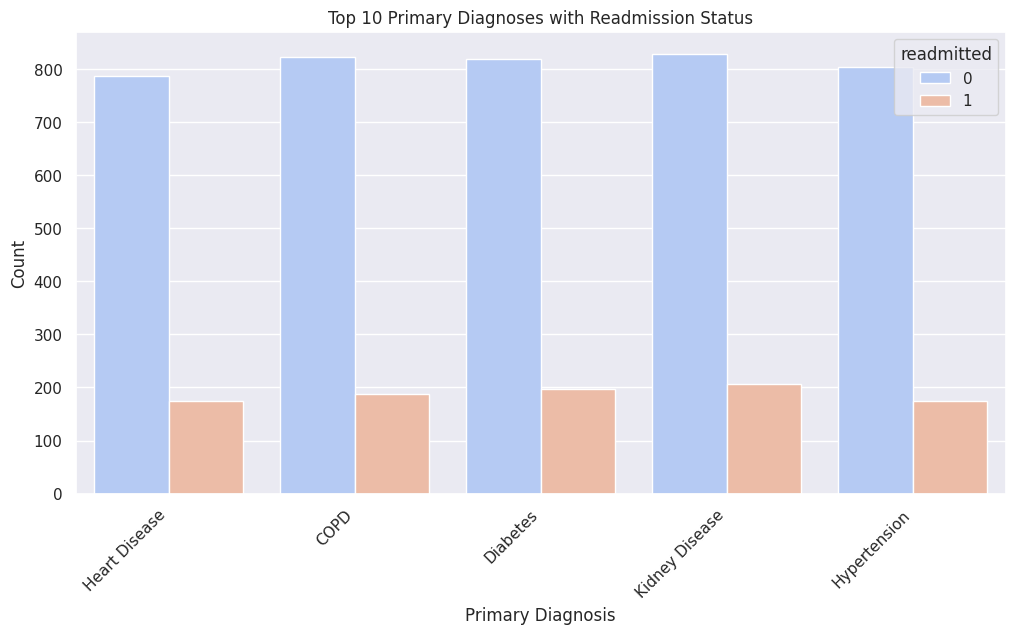

In [11]:
# Primary Diagnosis Breakdown
plt.figure(figsize=(12, 6))
primary_diag_count = train['primary_diagnosis'].value_counts().nlargest(10).index
sns.countplot(data=train[train['primary_diagnosis'].isin(primary_diag_count)], x='primary_diagnosis', hue='readmitted', palette='coolwarm')
plt.title('Top 10 Primary Diagnoses with Readmission Status')
plt.xlabel('Primary Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

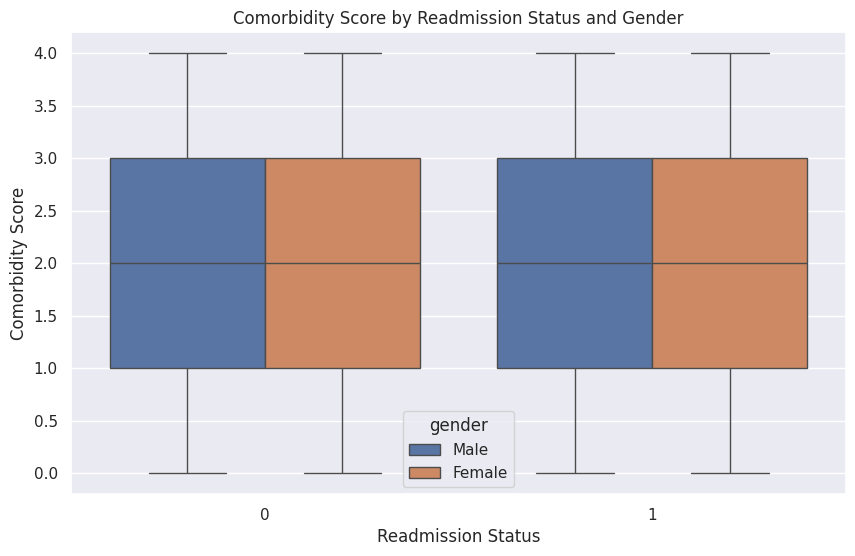

In [12]:
# Comorbidity Score Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='readmitted', y='comorbidity_score', hue='gender')
plt.title('Comorbidity Score by Readmission Status and Gender')
plt.xlabel('Readmission Status')
plt.ylabel('Comorbidity Score')
plt.show()

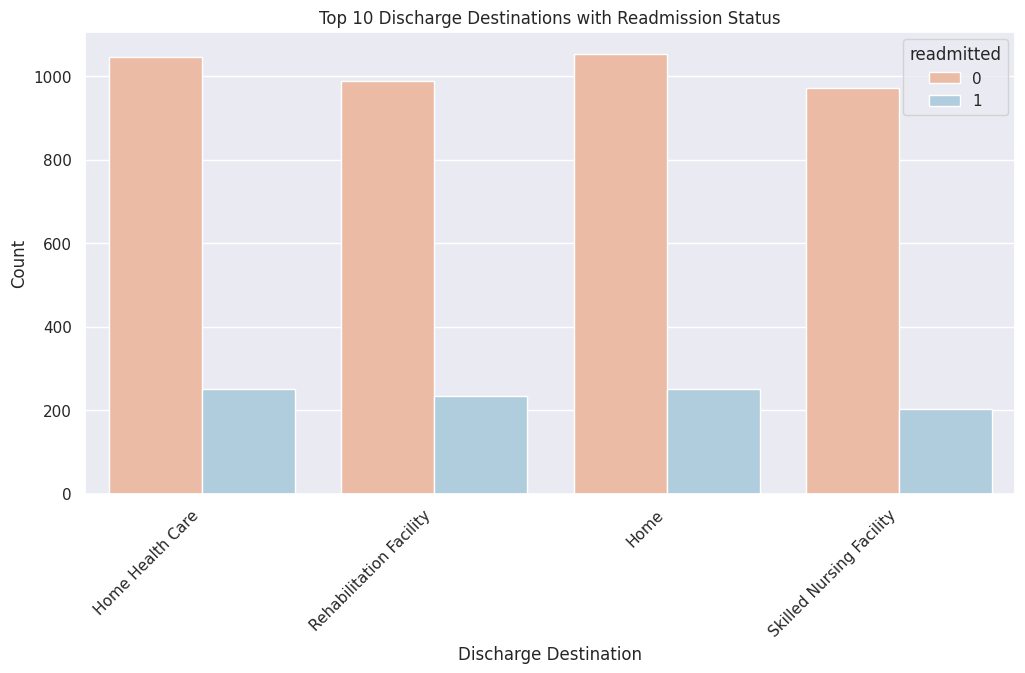

In [13]:
# Discharge Destination and Readmission Rates
plt.figure(figsize=(12, 6))
discharge_count = train['discharge_to'].value_counts().nlargest(10).index
sns.countplot(data=train[train['discharge_to'].isin(discharge_count)], x='discharge_to', hue='readmitted', palette='RdBu')
plt.title('Top 10 Discharge Destinations with Readmission Status')
plt.xlabel('Discharge Destination')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Feature Engineering

In [14]:
# Function to create Age Group Bucketing
def add_age_group(df):
    bins = [18, 30, 45, 60, 75, 100]
    labels = ['18-30', '31-45', '46-60', '61-75', '76+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False, include_lowest=True)
    df['age_group'] = df['age_group'].cat.add_categories('Other').fillna('Other')

# Function to Group Primary Diagnosis
def add_diagnosis_group(df):
    diagnosis_mapping = {
        'Hypertension': 'Cardiac',
        'Heart Attack': 'Cardiac',
        'Asthma': 'Respiratory',
        'COPD': 'Respiratory',
        'Diabetes': 'Diabetes-related'
    }
    df['diagnosis_group'] = df['primary_diagnosis'].map(diagnosis_mapping).fillna('Other')

# Function to create Hospital Stay Features
def add_hospital_stay_features(df):
    stay_bins = [0, 3, 7, 14, np.inf]
    stay_labels = ['0-3 days', '4-7 days', '8-14 days', '>14 days']
    df['stay_bucket'] = pd.cut(df['days_in_hospital'], bins=stay_bins, labels=stay_labels)
    df['stay_bucket'] = df['stay_bucket'].cat.add_categories('Other').fillna('Other')

    df['long_stay'] = np.where(df['days_in_hospital'] > 7, 1, 0)
    df['long_stay'] = df['long_stay'].fillna(-1)

# Function to create Procedure Features
def add_procedure_features(df):
    procedure_bins = [0, 1, 3, 5, np.inf]
    procedure_labels = ['None', '1-2', '3-5', '5+']
    df['procedure_category'] = pd.cut(df['num_procedures'], bins=procedure_bins, labels=procedure_labels)
    df['procedure_category'] = df['procedure_category'].cat.add_categories('Other').fillna('Other')

    df['procedures_diagnosis_interaction'] = df['num_procedures'] * df['diagnosis_group'].factorize()[0]

# Function to create Comorbidity Features
def add_comorbidity_features(df):
    comorbidity_threshold = 3
    df['high_risk_comorbidity'] = np.where(df['comorbidity_score'] >= comorbidity_threshold, 1, 0)
    df['high_risk_comorbidity'] = df['high_risk_comorbidity'].fillna(-1)


# Function to create Interaction Terms
def add_interaction_features(df):
    df['age_comorbidity_interaction'] = df['age'] * df['comorbidity_score']
    df['procedures_age_interaction'] = df['num_procedures'] * df['age']
    df['procedures_comorbidity_interaction'] = df['num_procedures'] * df['comorbidity_score']

# Master function to apply all feature engineering
def apply_feature_engineering(df):
    add_age_group(df)
    add_diagnosis_group(df)
    add_hospital_stay_features(df)
    add_procedure_features(df)
    add_comorbidity_features(df)
    add_interaction_features(df)
    return df

# Apply the feature engineering to both train and test
train = apply_feature_engineering(train)
test = apply_feature_engineering(test)


In [15]:
# Check for differences in columns between train and test
train_columns = set(train.columns)
test_columns = set(test.columns)

# Columns in train but not in test
unique_to_train = train_columns - test_columns

# Columns in test but not in train
unique_to_test = test_columns - train_columns

# Print the unique columns
print("Columns unique to train:", unique_to_train)
print("Columns unique to test:", unique_to_test)

# Check if train and test have the same columns
if unique_to_train or unique_to_test:
    print("Train and test do not have the same columns.")
else:
    print("Train and test have the same columns.")


Columns unique to train: {'readmitted'}
Columns unique to test: set()
Train and test do not have the same columns.


# Modeling

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       826
           1       0.20      0.36      0.26       174

    accuracy                           0.64      1000
   macro avg       0.52      0.53      0.51      1000
weighted avg       0.73      0.64      0.67      1000

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       826
           1       0.17      0.07      0.10       174

    accuracy                           0.78      1000
   macro avg       0.50      0.50      0.49      1000
weighted avg       0.71      0.78      0.74      1000

Training Gradient Boosting...

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       826
           1       0.00  

<Figure size 1200x600 with 0 Axes>

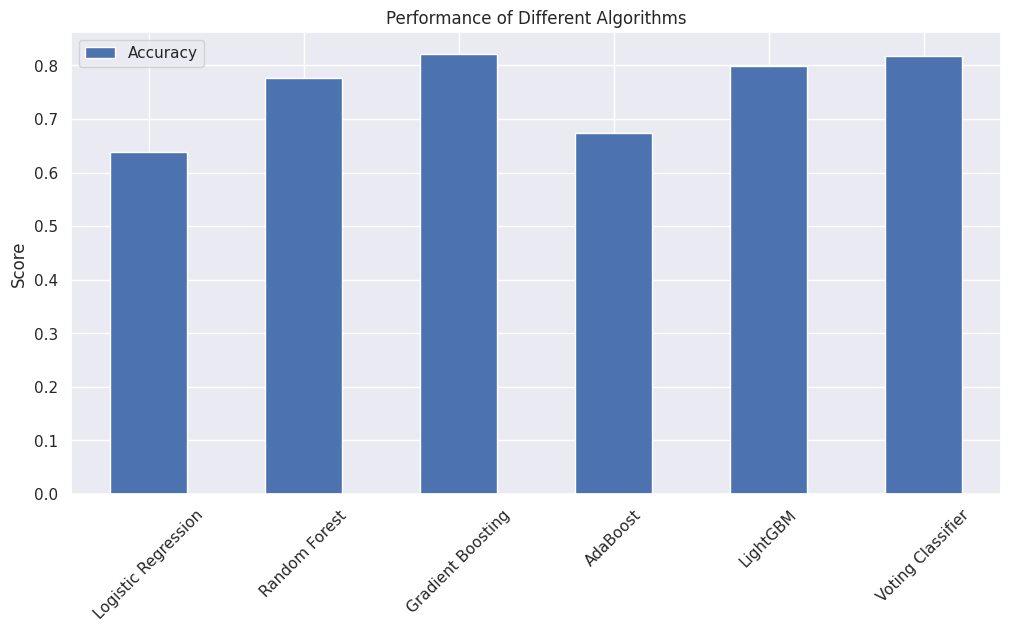

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC


# Define the target and features
X = train.drop(columns=['readmitted'])  # Features
y = train['readmitted']  # Target

# Identify categorical columns (assuming they're still not numeric)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTENC to balance the data (for categorical + numerical data)
smote = SMOTENC(categorical_features=[X.columns.get_loc(col) for col in categorical_cols], random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Initialize a Voting Classifier (hard voting, can also try 'soft' voting)
voting_clf = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']),
    ('rf', models['Random Forest']),
    ('gb', models['Gradient Boosting']),
    ('ab', models['AdaBoost']),
    ('lgbm', models['LightGBM']),
], voting='hard')

models['Voting Classifier'] = voting_clf

# Evaluate each model and store results
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_smote, y_train_smote)

    # Predict on the test set
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int) if hasattr(model, "predict_proba") else y_pred_prob

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if hasattr(model, "predict_proba") else 'N/A'

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    results[model_name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    }

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results).T

# Plot the results
plt.figure(figsize=(12, 6))
results_df[['Accuracy', 'ROC AUC']].plot(kind='bar', figsize=(12,6))
plt.title('Performance of Different Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


**Still terrible at predicting readmission (class 1). More work needs to be done.**